# Solar Jitter Approximation

This notebook exists to align the functions in `Functions.py` to the real measurements from the PSPT dataset. 

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd

from Functions import *
from tqdm.notebook import tqdm

Load in the Sunspot numbers of time, and select the period that overlaps with the PSPT dataset

In [2]:
spots_real = pd.read_csv('BelgiumMonthlySunspotNum.csv')

dates = spots_real['Fractional_Date'][spots_real['Definitive_Provisional_Marker'] == 1]
spots = spots_real['Monthly_Mean_Sunspot_Number'][spots_real['Definitive_Provisional_Marker'] == 1]

PSPT_dates = dates[(dates > 2005.0) & (dates < 2015.5)]
PSPT_spots = spots[(dates > 2005.0) & (dates < 2015.5)] * 27/30 # adjust for rotation period of sun

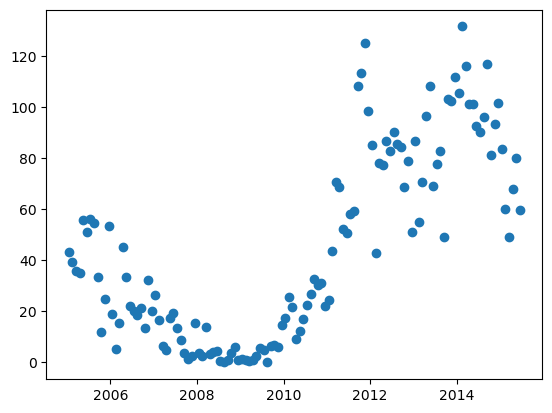

In [3]:
plt.scatter(PSPT_dates, PSPT_spots)

We found that spot size distribution that by itself fit best with observed data was the 'Baumann Group Max' default in `get_spot_sizes`. However, this lacked the occasional large deflection seen in the real data. After trying several different combinations, it was found that if 15% of the time, the spot sizes were sampled from the 'Nagovitsyn' distribution, the large deflections in the simulated data started to match the real data. Additionally, we modified the butterfly latitude selection to have a mean of 25 degrees, so that the polar scatter was better matched.  

The number of observations does have an impact on the final distribution, so we set it to 10, which is twice the daily average cadence of the PSPT telescope, but matches the hourly average cadence of the PSPT telescope (as half the time, the sun is set).

When using the Nagovitsyn distribution, we used 60% of the number of spots, as this aligns with the proportion of the spots that are 'long lived'. See the paper listed in the doc string for `get_spot_sizes' for details.

Given the simplicity of this model, and the general disagreement within Sunspot science (regarding populations, size distributions, etc), this adjustments are reasonable to be used as a baseline. 

In [4]:
np.random.seed(0)

xs = np.array([])
ys = np.array([])

n_observations = 10

for i in tqdm(range(1)):
    for n in tqdm(PSPT_spots.values):
        if np.random.uniform() >= 0.15:
            spot_radii  = get_spot_sizes(int(n), method = 'Baumann Group Max', reject_small = False)
        else:
            spot_radii  = get_spot_sizes(int(3*n/5), method = 'Nagovitsyn', reject_small = True)
            
        spot_phis   = spot_latitude_selection(len(spot_radii), method = 'butterfly', mean = 25, sigma = 6) * np.pi/180
        spot_thetas = np.random.uniform(low = 0, high = 2*np.pi, size = len(spot_radii))
        contrasts   = 0.7*np.ones(np.shape(spot_radii))
        obs_phi     = np.random.uniform(low = -7.25, high = 7.25, size = 1) * np.pi/180 # Solar B0 angle
    
        _, clean_data, _ = get_data(spot_radii, spot_thetas, spot_phis, contrasts, obs_phi,
                                    n_observations = n_observations , num_pts = 300**2, verbose = False)
    
        x = clean_data[:n_observations]
        y = clean_data[n_observations:]
    
        xs = np.concatenate((xs, x))
        ys = np.concatenate((ys, y))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

In [5]:
red = pd.read_csv('PSPT_Analysed_DFs/FinalRed.csv')
red = red.drop(columns=['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0']).dropna()
red_x = red['Scaled Rotated Jitter X (R☉)'].values
red_y = red['Scaled Rotated Jitter Y (R☉)'].values

blu = pd.read_csv('PSPT_Analysed_DFs/FinalBlue.csv')
blu = blu.drop(columns=['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0']).dropna()
blu_x = blu['Scaled Rotated Jitter X (R☉)'].values
blu_y = blu['Scaled Rotated Jitter Y (R☉)'].values

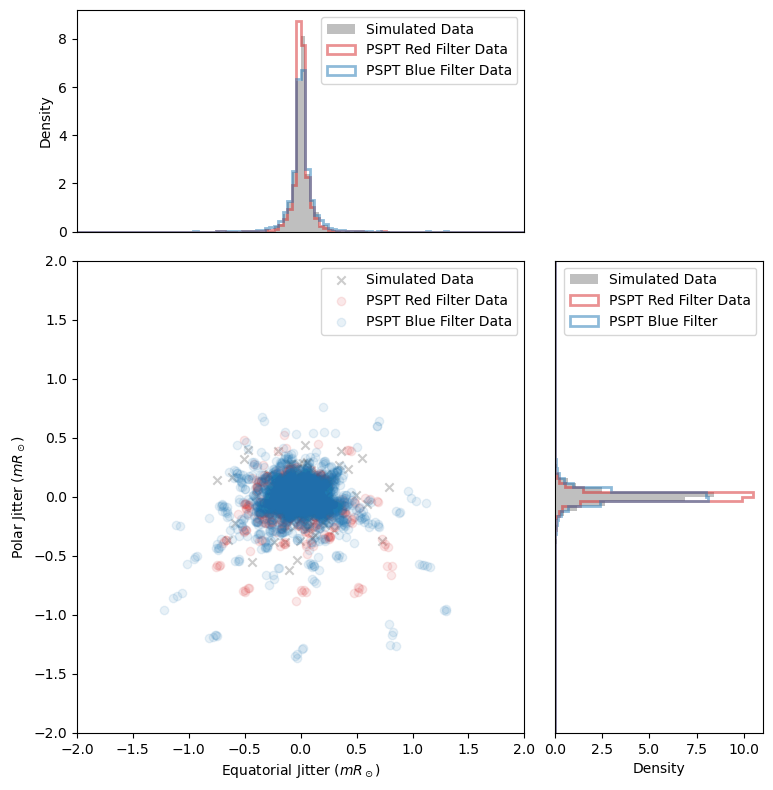

In [6]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(3, 3)

# Create the main scatter plot
ax_scatter = fig.add_subplot(gs[1:, :-1])
ax_scatter.scatter(xs*1000, ys*1000, alpha=0.2, color = 'black', marker = 'x', label = 'Simulated Data')
ax_scatter.scatter(red_x*1000,  red_y*1000, alpha=0.1, color = 'tab:red', label = 'PSPT Red Filter Data')
ax_scatter.scatter(blu_x*1000,  blu_y*1000, alpha=0.1, color = 'tab:blue', label = 'PSPT Blue Filter Data')
ax_scatter.legend()
ax_scatter.set_xlim([-2,2])
ax_scatter.set_ylim([-2,2])
ax_scatter.set_xlabel(r'Equatorial Jitter $(mR_\odot)$')
ax_scatter.set_ylabel(r'Polar Jitter $(mR_\odot)$')

ax_histx = fig.add_subplot(gs[0, :-1], sharex=ax_scatter)
ax_histx.hist(xs*1000, bins=np.linspace(-2,2,101), alpha=0.25, density = True, 
              color = 'black', label = 'Simulated Data')
ax_histx.hist(red_x*1000, bins=np.linspace(-2,2,101), alpha=0.5, density = True, 
              color = 'tab:red', histtype = 'step', lw = 2, label = 'PSPT Red Filter Data')
ax_histx.hist(blu_x*1000, bins=np.linspace(-2,2,101), alpha=0.5, density = True, 
              color = 'tab:blue', histtype = 'step', lw = 2, label = 'PSPT Blue Filter Data')
ax_histx.tick_params(axis='x', which='both', length=0, labelbottom=False, labelleft=False)
ax_histx.legend()
ax_histx.set_ylabel('Density')

ax_histy = fig.add_subplot(gs[1:, -1], sharey=ax_scatter)
ax_histy.hist(ys*1000, bins=np.linspace(-2,2,101), orientation='horizontal', alpha=0.25, density = True,
              color = 'black', label = 'Simulated Data')
ax_histy.hist(red_y*1000, bins=np.linspace(-2,2,101), orientation='horizontal', alpha=0.5, density = True,
              color = 'tab:red', histtype = 'step', lw = 2, label = 'PSPT Red Filter Data')
ax_histy.hist(blu_y*1000, bins=np.linspace(-2,2,101), orientation = 'horizontal', alpha=0.5, density = True, 
              color = 'tab:blue', histtype = 'step', lw = 2, label = 'PSPT Blue Filter')
ax_histy.tick_params(axis='y', which='both', length=0, labelbottom=False, labelleft=False)
ax_histy.legend()
ax_histy.set_xlabel('Density')

plt.tight_layout()

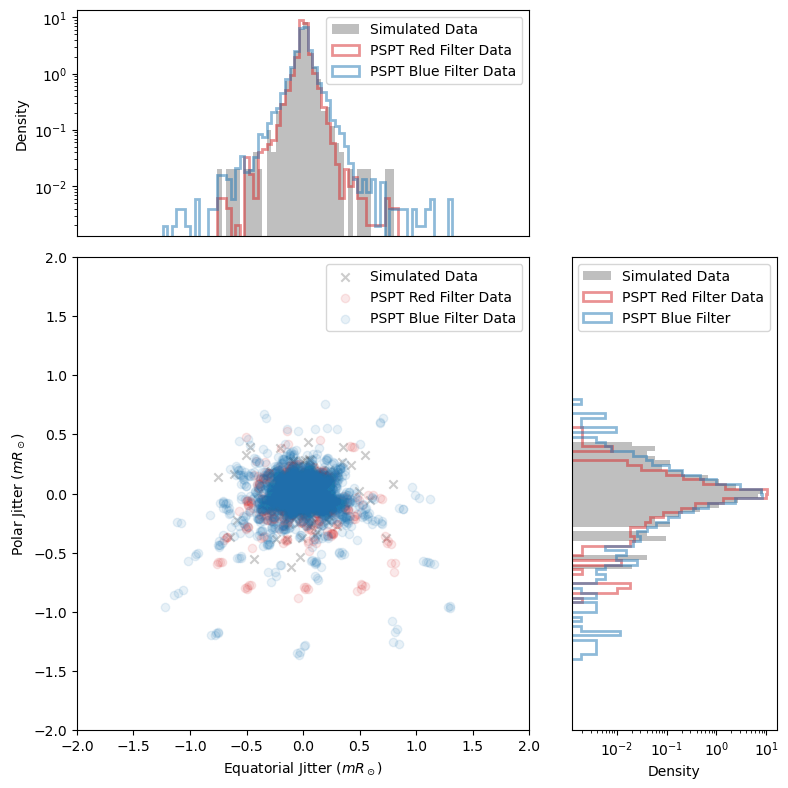

In [7]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(3, 3)

ax_scatter = fig.add_subplot(gs[1:, :-1])
ax_scatter.scatter(xs*1000, ys*1000, alpha=0.2, color = 'black', marker = 'x', label = 'Simulated Data')
ax_scatter.scatter(red_x*1000,  red_y*1000, alpha=0.1, color = 'tab:red', label = 'PSPT Red Filter Data')
ax_scatter.scatter(blu_x*1000,  blu_y*1000, alpha=0.1, color = 'tab:blue', label = 'PSPT Blue Filter Data')
ax_scatter.legend()
ax_scatter.set_xlim([-2,2])
ax_scatter.set_ylim([-2,2])
ax_scatter.set_xlabel(r'Equatorial Jitter $(mR_\odot)$')
ax_scatter.set_ylabel(r'Polar Jitter $(mR_\odot)$')


ax_histx = fig.add_subplot(gs[0, :-1], sharex=ax_scatter)
ax_histx.hist(xs*1000, bins=np.linspace(-2,2,101), alpha=0.25, density = True, 
              color = 'black', label = 'Simulated Data')
ax_histx.hist(red_x*1000, bins=np.linspace(-2,2,101), alpha=0.5, density = True, 
              color = 'tab:red', histtype = 'step', lw = 2, label = 'PSPT Red Filter Data')
ax_histx.hist(blu_x*1000, bins=np.linspace(-2,2,101), alpha=0.5, density = True, 
              color = 'tab:blue', histtype = 'step', lw = 2, label = 'PSPT Blue Filter Data')
ax_histx.tick_params(axis='x', which='both', length=0, labelbottom=False, labelleft=False)
ax_histx.legend()
ax_histx.set_ylabel('Density')
ax_histx.set_yscale('log')

ax_histy = fig.add_subplot(gs[1:, -1], sharey=ax_scatter)
ax_histy.hist(ys*1000, bins=np.linspace(-2,2,101), orientation='horizontal', alpha=0.25, density = True,
              color = 'black', label = 'Simulated Data')
ax_histy.hist(red_y*1000, bins=np.linspace(-2,2,101), orientation='horizontal', alpha=0.5, density = True,
              color = 'tab:red', histtype = 'step', lw = 2, label = 'PSPT Red Filter Data')
ax_histy.hist(blu_y*1000, bins=np.linspace(-2,2,101), orientation = 'horizontal', alpha=0.5, density = True, 
              color = 'tab:blue', histtype = 'step', lw = 2, label = 'PSPT Blue Filter')
ax_histy.tick_params(axis='y', which='both', length=0, labelbottom=False, labelleft=False)
ax_histy.legend()
ax_histy.set_xlabel('Density')
ax_histy.set_xscale('log')

plt.tight_layout()

In [8]:
print(f'Red X STD: {np.std(red_x*1000):.3e}', f'Blue X STD: {np.std(blu_x*1000):.3e}', f'Sim X STD: {np.std(xs*1000):.3e}')
print(f'Red Y STD: {np.std(red_y*1000):.3e}', f'Blue Y STD: {np.std(blu_y*1000):.3e}', f'Sim Y STD: {np.std(ys*1000):.3e}')

Red X STD: 8.004e-02 Blue X STD: 1.217e-01 Sim X STD: 9.807e-02
Red Y STD: 5.753e-02 Blue Y STD: 9.974e-02 Sim Y STD: 8.058e-02


In [9]:
red_x_err, red_x_ci = bootstrap(red_x*1000, return_CI = True)
red_y_err, red_y_ci = bootstrap(red_y*1000, return_CI = True)

blu_x_err, blu_x_ci = bootstrap(blu_x*1000, return_CI = True)
blu_y_err, blu_y_ci = bootstrap(blu_y*1000, return_CI = True)

xs_err, xs_ci = bootstrap(xs*1000, return_CI = True)
ys_err, ys_ci = bootstrap(ys*1000, return_CI = True)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
print(np.array([blu_x_ci[0], blu_x_ci[1]]).reshape(2,-1))

[[0.11692335]
 [0.12651009]]


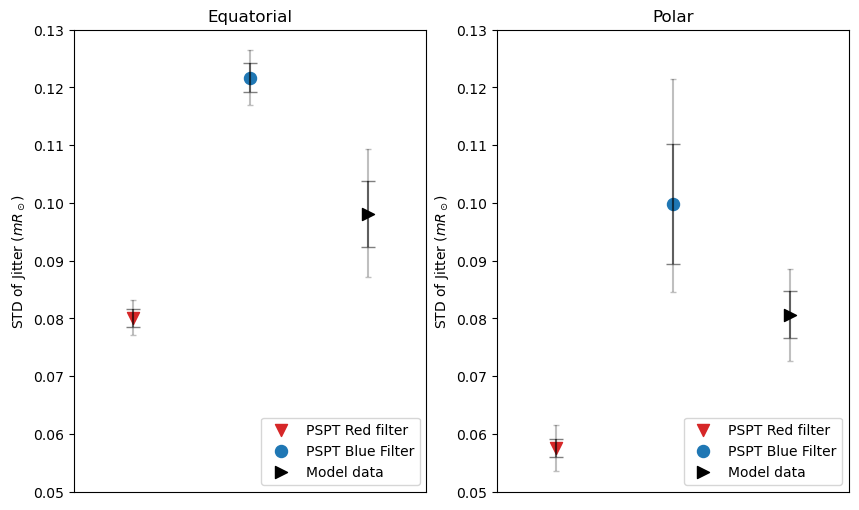

In [11]:
plt.figure(figsize = (10,6))

plt.subplot(1,2,1)
plt.errorbar(0, np.std(red_x*1000), yerr =  red_x_err, fmt = '', color = 'black', alpha = 0.5, capsize = 5)
plt.errorbar(0, np.std(red_x*1000), yerr =  np.array([np.std(red_x*1000)-red_x_ci[0], red_x_ci[1]-np.std(red_x*1000)]).reshape(2,-1), fmt = '', color = 'black', alpha = 0.25, capsize = 2)
plt.scatter(0, np.std(red_x*1000), color = 'tab:red', marker = 'v', s = 75, label = 'PSPT Red filter')
plt.errorbar(1, np.std(blu_x*1000), yerr =  blu_x_err, fmt = '', color = 'black', alpha = 0.5, capsize = 5)
plt.errorbar(1, np.std(blu_x*1000), yerr =  np.array([np.std(blu_x*1000)-blu_x_ci[0], blu_x_ci[1]-np.std(blu_x*1000)]).reshape(2,-1), fmt = '', color = 'black', alpha = 0.25, capsize = 2)
plt.scatter(1, np.std(blu_x*1000), color = 'tab:blue', s = 75, label = 'PSPT Blue Filter')
plt.errorbar(2, np.std(xs*1000), yerr =  xs_err, fmt = '', color = 'black', alpha = 0.5, capsize = 5)
plt.errorbar(2, np.std(xs*1000), yerr =  np.array([np.std(xs*1000)-xs_ci[0], xs_ci[1]-np.std(xs*1000)]).reshape(2,-1), fmt = '', color = 'black', alpha = 0.25, capsize = 2)
plt.scatter(2, np.std(xs*1000), color = 'black', s = 75, marker = '>', label = 'Model data')
plt.xlim([-0.5, 2.5])
plt.xticks([])
plt.ylabel(r'STD of Jitter ($mR_\odot$)')
plt.title('Equatorial')
plt.ylim([0.05, 0.13])
plt.legend(loc = 'lower right')


plt.subplot(1,2,2)
plt.errorbar(0, np.std(red_y*1000), yerr =  red_x_err, fmt = '', color = 'black', alpha = 0.5, capsize = 5)
plt.errorbar(0, np.std(red_y*1000), yerr =  np.array([np.std(red_y*1000)-red_y_ci[0], red_y_ci[1]-np.std(red_y*1000)]).reshape(2,-1), fmt = '', color = 'black', alpha = 0.25, capsize = 2)
plt.scatter(0, np.std(red_y*1000), color = 'tab:red', marker = 'v', s = 75, label = 'PSPT Red filter')
plt.errorbar(1, np.std(blu_y*1000), yerr =  blu_y_err, fmt = '', color = 'black', alpha = 0.5, capsize = 5)
plt.errorbar(1, np.std(blu_y*1000), yerr =  np.array([np.std(blu_y*1000)-blu_y_ci[0], blu_y_ci[1]-np.std(blu_y*1000)]).reshape(2,-1), fmt = '', color = 'black', alpha = 0.25, capsize = 2)
plt.scatter(1, np.std(blu_y*1000), color = 'tab:blue', s = 75, label = 'PSPT Blue Filter')
plt.errorbar(2, np.std(ys*1000), yerr =  ys_err, fmt = '', color = 'black', alpha = 0.5, capsize = 5)
plt.errorbar(2, np.std(ys*1000), yerr =  np.array([np.std(ys*1000)-ys_ci[0], ys_ci[1]-np.std(ys*1000)]).reshape(2,-1), fmt = '', color = 'black', alpha = 0.25, capsize = 2)
plt.scatter(2, np.std(ys*1000), color = 'black', s = 75, marker = '>', label = 'Model data')
plt.xlim([-0.5, 2.5])
plt.xticks([])
plt.ylabel(r'STD of Jitter ($mR_\odot$)')
plt.title('Polar')
plt.ylim([0.05, 0.13])
plt.legend(loc = 'lower right')


The plot above displays the astrometric jitter, represented by the standard deviation of astrometric deflection, for the two quiet Sun PSPT filters compared with model data. The error bar closer to each point (with larger caps) indicates the standard deviation of the jitter obtained through bootstrapping, while the larger error bar (with smaller caps) represents the 95% confidence interval. Note that the model data has limb darkening for 550nm, and has a single spot contrast (0.7), which overlaps possible spot contrasts in both the red and blue filters.









In [14]:
results = make_observations(n_rotations = 12, 
                            num_spots = 80,
                            radii_method = ['Nagovitsyn'],
                            radii_probs = np.array([1]),
                            latitude_method = ['butterfly'],
                            obs_phi = np.array([0]))
                            

TypeError: unsupported operand type(s) for |: 'int' and 'type'